In [1]:
import os
import sys
# os.chdir('../')
sys.path.append(os.getcwd())

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.decomposition import PCA
from scipy.stats import fisher_exact, chi2_contingency
from sklearn.manifold import TSNE, MDS
from tqdm import tqdm
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score, precision_score, recall_score, roc_curve
from multipy.fwer import sidak, hochberg
import random

from utils.viz_utils import plot_usage_matrix_pca, plot_boxplots_for_usage_matrix, _plot_feature_importance, plot_v_usage_hist, \
                                plot_cluster_map, significant_clones_distribution, plot_results_for_hla_class, plot_generated_to_real_distribution, \
                            plot_olga_cleanup_data, plot_clusters_of_clonotypes, plot_cooccurence_heatmap_with_epitopes_labeling, plot_waterfall_by_column, \
                            plot_feature_importances
from utils.ml_utils import get_parameters, prepare_data, evaluate_models, split_data_by_batch, split_data, cross_validation_between_batches, make_hla_predictor
from utils.data_utils import prepare_run_column
from utils.stats_utils import evaluate_anova_testing, evaluate_mannwhitneyu_testing
from utils.clustering_utils import seqs2hamming
from utils.weblogo_utils import create_web_logo


import warnings
warnings.filterwarnings('ignore')


import importlib
imported_module = importlib.import_module("utils.viz_utils")
importlib.reload(imported_module)

<module 'utils.viz_utils' from '/home/evlasova/tcr-covid-classifier/utils/viz_utils.py'>

In [2]:
def prepare_data_for_joint_classifiers(features_type, use_hla):
    data_alpha_for_joint = prepare_data(run_to_number_of_clones_path='data/run_to_number_of_clones_fmba_TRA.csv',
                     desc_path='data/standardized_usage_matrix_fmba_TRA_v.csv',
                     clonotype_matrix_path='data/significant_clone_matrix_fisher_fmba_TRA_top_500k_wo_leaks.csv',
                     hla_keys_path='data/hla_keys.csv',
                     make_freq= features_type == 'freq',
                     make_all_features_bool= features_type == 'bool',
                     make_all_features_categorial= features_type == 'categorial',
                     use_hla_clones=False,
                     use_hla_bool=False,
                     use_standardization=True,
                     raw_target_column='covid',
                     raw_target_clumn_success_label='covid',
                     metadata_columns=['is_test_run', 'project'])
    data_beta_for_joint = prepare_data(run_to_number_of_clones_path='data/run_to_number_of_clones_fmba_TRB.csv',
                         desc_path='data/standardized_usage_matrix_fmba_TRA_v.csv',
                         clonotype_matrix_path='data/significant_clone_matrix_fisher_fmba_TRB_top_500k_wo_leaks.csv',
                         hla_keys_path='data/hla_keys.csv',
                         make_freq= features_type == 'freq',
                         make_all_features_bool= features_type == 'bool',
                         make_all_features_categorial= features_type == 'categorial',
                         use_hla_clones=False, 
                         use_hla_bool=use_hla, 
                         use_standardization=True,
                         raw_target_column='covid',
                         raw_target_clumn_success_label='covid',
                         metadata_columns=[]).drop(columns=['covid'])
    data_joint = pd.concat([data_beta_for_joint, data_alpha_for_joint], axis=1).reset_index(drop=True)
    return data_joint


In [3]:
def prepare_data_for_meta_joint_classifiers(features_type, use_hla):
    data_beta_meta = prepare_data(run_to_number_of_clones_path='data/run_to_number_of_clones_fmba_TRB.csv',
                     desc_path='data/standardized_usage_matrix_fmba_TRA_v.csv',
                     clonotype_matrix_path='data/clone_matrix_covid_fmba_TRB_metaclone.csv',
                     hla_keys_path='data/hla_keys.csv',
                     make_freq= features_type == 'freq',
                     make_all_features_bool= features_type == 'bool',
                     make_all_features_categorial= features_type == 'categorial',
                     use_hla_clones=False,
                     use_hla_bool=use_hla,
                     use_standardization=True,
                     raw_target_column='covid',
                     raw_target_clumn_success_label='covid',
                     metadata_columns=['is_test_run', 'project'])

    data_alpha_meta = prepare_data(run_to_number_of_clones_path='data/run_to_number_of_clones_fmba_TRA.csv',
                         desc_path='data/standardized_usage_matrix_fmba_TRA_v.csv',
                         clonotype_matrix_path='data/clone_matrix_covid_fmba_TRA_metaclone.csv',
                         hla_keys_path='data/hla_keys.csv',
                         make_freq= features_type == 'freq',
                         make_all_features_bool= features_type == 'bool',
                         make_all_features_categorial= features_type == 'categorial',
                         use_hla_clones=False,
                         use_hla_bool=False,
                         use_standardization=True,
                         raw_target_column='covid',
                         raw_target_clumn_success_label='covid',
                         metadata_columns=[]).drop(columns=['covid'])

    data_beta_meta = data_beta_meta.rename(columns={f'cluster_{x}': f'b_cluster_{x}' for x in range(len(data_beta_meta.columns))})
    data_alpha_meta = data_alpha_meta.rename(columns={f'cluster_{x}': f'a_cluster_{x}' for x in range(len(data_beta_meta.columns))})
    data_joint_meta = pd.concat([data_beta_meta, data_alpha_meta], axis=1).reset_index(drop=True)
    return data_joint_meta

In [4]:
X_train_dct = {}
y_train_dct = {}
X_test_dct = {}
y_test_dct = {}
best_clfs = {}

markers = []
biomarkers = []
hlas = []
features = []
f1_scores = []
precisions = []
recalls = []

In [5]:
model_type = 'svm'
for biomarkers_type in ['usual', 'joint']:
    for use_hla in [False, True]:
        for features_type in ['bool', 'categorial', 'freq']:
            current_marker = f'biomarkers_{biomarkers_type}_hla_{use_hla}_features_{features_type}'
            print(f'evaluating {current_marker}')
            if biomarkers_type == 'usual':
                data = prepare_data_for_joint_classifiers(features_type, use_hla)
            else:
                data = prepare_data_for_meta_joint_classifiers(features_type, use_hla)
            X_train, y_train, X_test, y_test = split_data(data=data.drop(columns=['project']), y_column='covid') 
            X_train_dct[current_marker] = X_train
            X_test_dct[current_marker] = X_test            
            y_train_dct[current_marker] = y_train
            y_test_dct[current_marker] = y_test
            clf = evaluate_models(X_train, y_train, X_test, y_test, get_parameters(models=[model_type]), scoring_function='f1_weighted', debug=True)[0][model_type]
            best_clfs[current_marker] = clf
            
            markers.append(current_marker)
            biomarkers.append(biomarkers_type)
            hlas.append(use_hla)
            features.append(features_type)
            f1_scores.append(f1_score(y_test, clf.predict(X_test)))
            precisions.append(precision_score(y_test, clf.predict(X_test)))
            recalls.append(recall_score(y_test, clf.predict(X_test)))

evaluating biomarkers_usual_hla_False_features_bool
Started evaluating svm
Best params for svm: {'model__C': 10, 'model__kernel': 'rbf', 'model__probability': True, 'model__random_state': 42}
Test f1-score for the best model 0.68

classifier   svm
f1-score    0.68
Best model is svm with params: {'model__C': 10, 'model__kernel': 'rbf', 'model__probability': True, 'model__random_state': 42}
evaluating biomarkers_usual_hla_False_features_categorial
Started evaluating svm
Best params for svm: {'model__C': 1, 'model__kernel': 'rbf', 'model__probability': True, 'model__random_state': 42}
Test f1-score for the best model 0.71

classifier       svm
f1-score    0.708333
Best model is svm with params: {'model__C': 1, 'model__kernel': 'rbf', 'model__probability': True, 'model__random_state': 42}
evaluating biomarkers_usual_hla_False_features_freq
Started evaluating svm
Best params for svm: {'model__C': 100, 'model__kernel': 'rbf', 'model__probability': True, 'model__random_state': 42}
Test f1-sco

In [6]:
resulting_df = pd.DataFrame({   
                                'marker': markers,
                                'biomarker_type': biomarkers,
                                'hla_used': hlas,
                                'feature_type': features, 
                                'f1': f1_scores,
                                'precision': precisions,
                                'recall': recalls
                            })

In [7]:
resulting_df

,marker,biomarker_type,hla_used,feature_type,f1,precision,recall
0,biomarkers_usual_hla_False_features_bool,usual,False,bool,0.680000,0.629630,0.739130
1,biomarkers_usual_hla_False_features_categorial,usual,False,categorial,0.708333,0.680000,0.739130
2,biomarkers_usual_hla_False_features_freq,usual,False,freq,0.761905,0.842105,0.695652
3,biomarkers_usual_hla_True_features_bool,usual,True,bool,0.680000,0.629630,0.739130
4,biomarkers_usual_hla_True_features_categorial,usual,True,categorial,0.680851,0.666667,0.695652
5,biomarkers_usual_hla_True_features_freq,usual,True,freq,0.731707,0.833333,0.652174
6,biomarkers_joint_hla_False_features_bool,joint,False,bool,0.625000,0.600000,0.652174
7,biomarkers_joint_hla_False_features_categorial,joint,False,categorial,0.680000,0.629630,0.739130
8,biomarkers_joint_hla_False_features_freq,joint,False,freq,0.681818,0.714286,0.652174
9,biomarkers_joint_hla_True_features_bool,joint,True,bool,0.708333,0.680000,0.739130


In [8]:
joint_df = resulting_df[resulting_df.biomarker_type == 'joint']

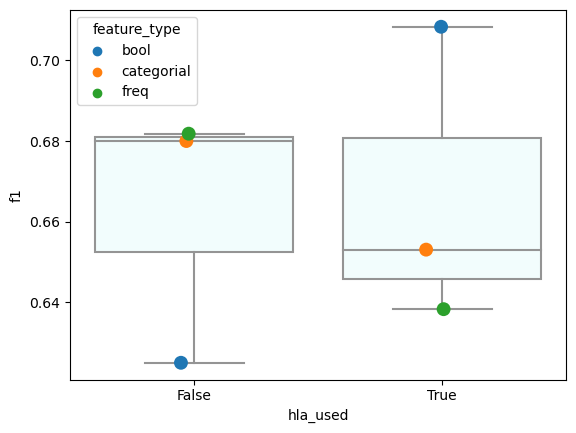

In [9]:
sns.stripplot(data=joint_df, x="hla_used", y="f1", hue="feature_type", s=10)
sns.boxplot(data=joint_df, x="hla_used", y="f1", color='azure')
plt.show()

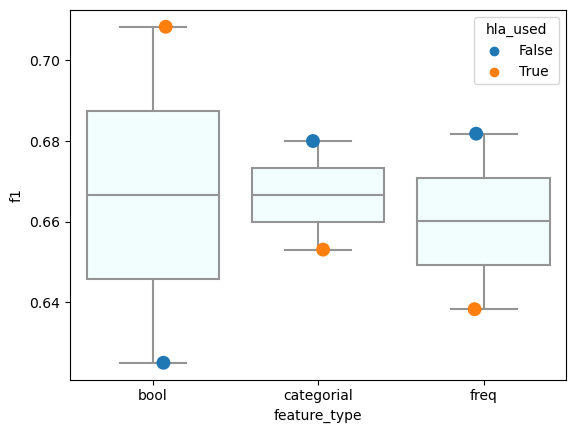

In [10]:
sns.stripplot(data=joint_df, x="feature_type", y="f1", hue="hla_used", s=10)
sns.boxplot(data=joint_df, x="feature_type", y="f1", color='azure')
plt.show()

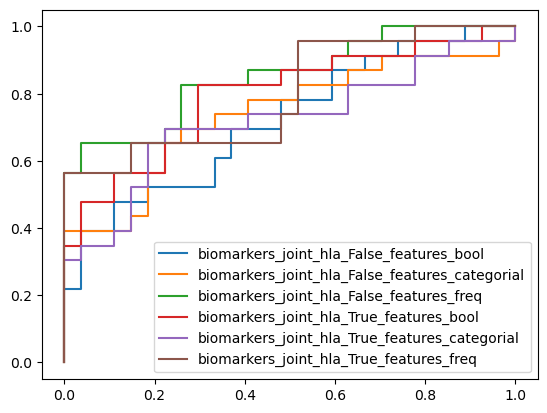

In [11]:
for key in joint_df.marker:
    fpr, tpr, _ = roc_curve(y_test_dct[key], best_clfs[key].predict_proba(X_test_dct[key])[::,1])
    plt.plot(fpr, tpr, label=key)
plt.legend()
plt.show()

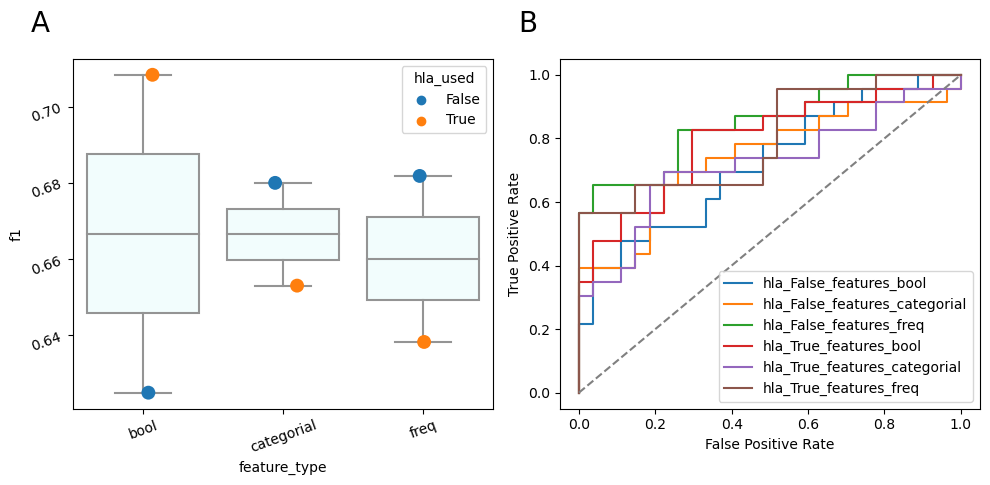

In [13]:
fig = plt.figure(figsize=(10, 5))
gs = GridSpec(nrows=1, 
              ncols=2)
font_size=20
delta_x=-0.1
delta_y=1.14

########################################################
ax1 = fig.add_subplot(gs[0, 1])

for key in joint_df.marker:
    fpr, tpr, _ = roc_curve(y_test_dct[key], best_clfs[key].predict_proba(X_test_dct[key])[::,1])
    ax1.plot(fpr, tpr, label=key.replace('biomarkers_joint_', ''))

ax1.set_ylabel('True Positive Rate')
ax1.set_xlabel('False Positive Rate')
ax1.plot([0, 1], [0, 1], linestyle='dashed', color='grey')
ax1.legend()
# ax3.set_title('ROC-curve')
ax1.text(delta_x, delta_y, 'B',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax1.transAxes,
        size=font_size)

########################################################

ax0 = fig.add_subplot(gs[0, 0])
sns.stripplot(data=joint_df, x="feature_type", y="f1", hue="hla_used", s=10, ax=ax0)
sns.boxplot(data=joint_df, x="feature_type", y="f1", color='azure', ax=ax0)
ax0.text(delta_x, delta_y, 'A',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax0.transAxes,
        size=font_size)
# ax9.set_title('Comparison of f1-score across models')
ax0.tick_params(labelrotation=20)

########################################################

plt.tight_layout()
plt.savefig("figures/supp_fig2.svg")
plt.savefig("figures/supp_fig2.pdf")
plt.savefig("figures/supp_fig2.png")
plt.show()
